# 선형회귀 예시 (1) - 다이아몬드 가격에 영향을 미치는 요인
## 1. 작업 준비
### 1) 패키지 및 데이터 가져오기
- R의 시각화 패키지인 `ggplot2`에 내장되어 있는 데이터셋으로 총 10개의 요인으로 이루어져 있으며 `53,940`개의 관측치가 있다.

| 변수 | 의미 | 기타 |
|---|---|---|
| carat | 무게 | ex) 3캐럿 다이아몬드 |
| cut | 세공의 질 | 다이아몬드의 단면을 어떻게 커팅하였는지에 대한 상태값을 분류<br/>계층이 있는 범주형(factor) 데이터<br/>"Fair", "Good", "Very Good", "Premium", "Ideal"로 나누어짐 |
| color | 컬러 | 총 7개의 색, 범주형 데이터<br/>
| clarity | 투명도 | 범주형 데이터 |
| depth | 깊이 | 수치형 데이터 |
| table | 넓은 폭 대비 꼭대기의 넓이 | 수치형 데이터 |
| price | 가격(`$`) | 수치형 데이터 |
| x | 길이 | 수치형 데이터 |
| y | 넓이 | 수치형 데이터 |
|  z | 깊이 | 수치형 데이터 |

In [2]:
import sys
sys.path.append('../../')
import helper               # 이렇게 참조할 경우: helper.함수명 으로 코딩해야 함

import numpy as np
from pandas import read_excel, DataFrame, melt, merge
from pca import pca
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# 정규분포 가성
from scipy.stats import skew, kurtosis

In [3]:
origin = read_excel('https://data.hossam.kr/E04/diamonds.xlsx')
origin

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## 2. 데이터 전처리
### 1) 데이터프레임 복사

In [4]:
edf = origin.copy()
edf.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 2) 결측치 확인

In [5]:
edf.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

> 결측치 없음

### 3) 데이터 타입 확인

In [6]:
edf.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

### 4) 일단 분석
#### 1. 회귀분석

In [7]:
tmp = edf.filter(['carat', 'depth', 'table', 'x', 'y', 'z', 'price'])
ols_result = helper.myOls(tmp, y='price',
                          x=['carat', 'depth', 'table', 'x', 'y', 'z'])
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:14:17   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.085e+04    447.562     46.584      0.0

> R-squared: 0.859로 설명력이 85%나 되어 좋아보이지만, 이 요인들이 영향을 준다는 결과를 더 확실하게 내기 위해 다른 검정 필요 (r-squared 값이 높아도 실은 이 요인들 중 영향력이 없는 것들이 있을 수 있음)
>
> Durbin-Watson 값도 확인해야 함 (Durbin-Watson은 독립변수가 독립성을 충족하는지 알려줌)

#### 2. 결과보고

In [8]:
print(ols_result.table)
print(ols_result.result, end='\n\n')
print(ols_result.goodness, end='\n\n')
for i in ols_result.varstr:
    print(i)

                      B    표준오차  β         t   유의확률          VIF
종속변수  독립변수                                                      
price carat   1.069e+04  63.201  0  169.085*  0.000   103.726117
      depth   -203.1541   5.504  0  -36.910*  0.000   516.456375
      table   -102.4457   3.084  0  -33.216*  0.000   501.097896
      x      -1315.6678  43.070  0  -30.547*  0.000  1288.946580
      y         66.3216  25.523  0    2.599*  0.009   531.485870
      z         41.6277  44.305  0    0.940*  0.347   543.235912
𝑅(0.859), 𝑅^2(0.859), 𝐹(5.486e+04), 유의확률(0.00), Durbin-Watson(1.249)

price에 대하여 carat,depth,table,x,y,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,53933) = 5.486e+04, p < 0.05).

carat의 회귀계수는 1.069e+04(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
depth의 회귀계수는 -203.1541(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
table의 회귀계수는 -102.4457(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
x의 회귀계수는 -1315.6678(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
y의 회귀계수는 66.3216(p<0.05)로, price에 대하여 유의미한 

#### 3. 잔차 분석
##### 결과치 생성

In [103]:
sdf = DataFrame({
    '관측값': edf['price'],
    '예측값': ols_result.fit.fittedvalues,
    '잔차': ols_result.fit.resid,
    'zscore': stats.zscore(ols_result.fit.fittedvalues)
})
sdf

,관측값,예측값,잔차,zscore
0,326,346.909718,-20.909718,-0.969700
1,326,-71.468765,397.468765,-1.082838
2,327,126.368674,200.631326,-1.029339
3,334,193.901639,140.098361,-1.011076
4,335,53.549591,281.450409,-1.049030
...,...,...,...,...
53935,2757,3314.909673,-557.909673,-0.167090
53936,2757,3135.402558,-378.402558,-0.215633
53937,2757,2503.140469,253.859531,-0.386610
53938,2757,4175.515769,-1418.515769,0.065635


##### 잔차의 정규성 - Q-Q Plot
- 생성한 결과치로 `Q-Q Plot`으로 `잔차의 정규성 검정`

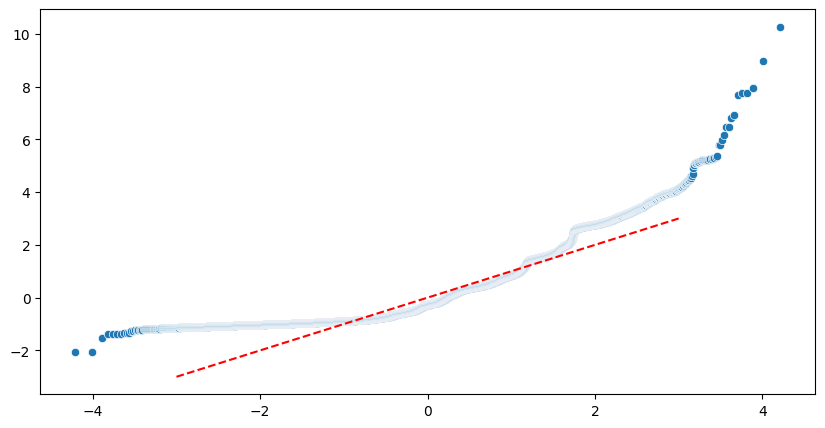

In [104]:
(x, y), _ = stats.probplot(sdf['zscore'])

plt.figure(figsize = (10, 5))
sb.scatterplot(x=x, y=y)
sb.lineplot(x=[-3, 3], y=[-3, 3], color = 'red', linestyle = '--')
plt.show()
plt.close()

> 잘 안 맞는 것을 알 수 있다.

##### 잔차의 정규성 - Kolmogorov Smirnov 검정 (정규성 검정 방법 중 하나)
- 생성한 결과치로 `Kolmogorov Smirnov 검정`으로 `잔차의 정규성 검정`
- `stats.kstest(잔차, 'norm')`
- Kolmogorov Smirnov 검정은 표본 수가 50개 이상인 경우에만 사용 (Shapiro 검정은 50개 미만인 경우에만 사용)

In [105]:
s, p = stats.kstest(sdf['잔차'], 'norm')
print("Kolmogorov Smirnov Test: (통계량, p-value) = ", (s, p))

if p > 0.05:
    print('잔차는 정규 분포를 따릅니다. (귀무가설 채택)')
else:
    print('잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)')

Kolmogorov Smirnov Test: (통계량, p-value) =  (0.5298424160389473, 0.0)
잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)


##### 잔차의 등분산성 (브로이슈 패건 검정)

In [106]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = het_breuschpagan(ols_result.fit.resid,
                               ols_result.fit.model.exog)
DataFrame(test_result, index=names)

,0
Lagrange multiplier statistic,9934.176446
p-value,0.000000
f-value,2029.200891
f p-value,0.000000


> 위의 각종 검정 결과(잔차 분석)를 종합 후, 앞서 했던 분석 결과를 신뢰할 수 없는 것으로 판단하고 재시도

### 5) 범주형 타입 변환
#### 1. 순서 있는 범주형 설정
- `CategoricalDtype(categories=['상태1', '상태2', '상태3'], ordered = True)`
    - ordered=True 파라미터는 순서가 있다는 것을 의미?

In [107]:
ctype = CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered = True)
edf['cut'] = edf['cut'].astype(ctype)
edf.dtypes

carat       float64
cut        category
color        object
clarity      object
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

#### 2. 순서 없는 범주형 설정

In [108]:
edf['color'] = edf['color'].astype('category')
edf['clarity'] = edf['clarity'].astype('category')
edf.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

## 3. 요인 선정을 위한 탐색적 데이터 분석
### 1) 수치형 변수
#### 1. 기초 통계량 확인
- 범주형 데이터는 자동으로 제외됨

In [109]:
desc = edf.describe()
desc

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


#### 2. boxplot 확인
- `일괄처리`
    - `seaborn.boxplot`의 파라미터를 `data = 데이터프레임`로 줌
    - 범주형 변수는 자동으로 제외 됨

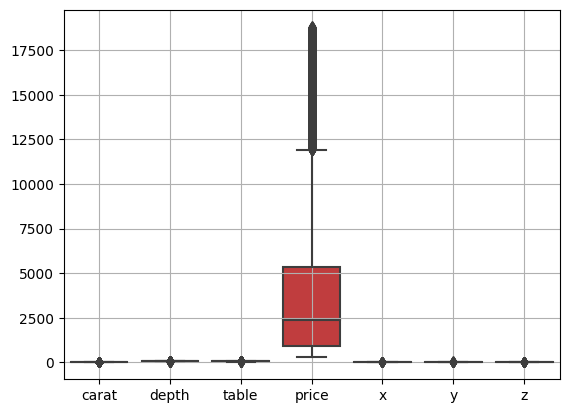

In [110]:
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

> 종속변수인 가격('price')를 제외하고는 비슷한 범위를 갖고 있으므로 표준화는 불필요한 것으로 판단

- `개별 컬럼`에 대한 boxplot
    - 범주형을 제외하고 처리해야 하므로 `describe()` 함수의 결과로 생성된 데이터프레임의 컬럼명에 대해서만 처리

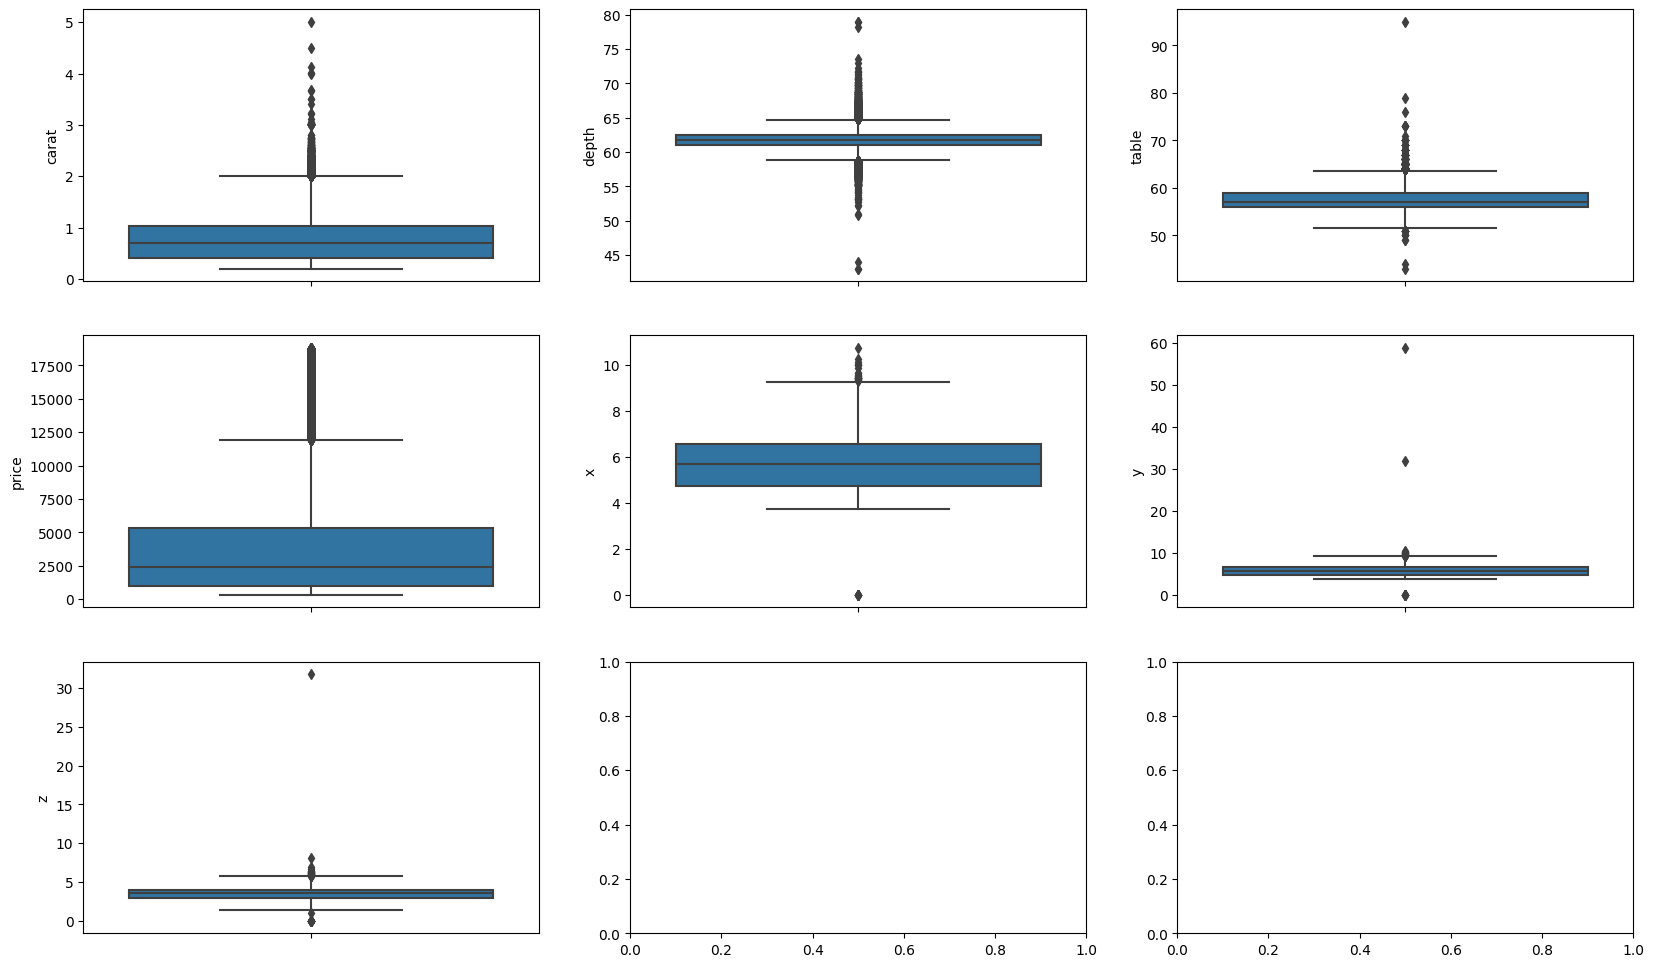

In [111]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
rows = len(ax)
cols = len(ax[0])

for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        # print("idx=%d, i=%d, j=%d" % (idx, i, j))
        sb.boxplot(data=edf, y=desc.columns[idx], ax = ax[i][j])
        # 무한으로 돌지 않게 하기 위해 박스플롯들을 다 만들었을 때 break 설정
        if idx + 1 == len(desc.columns):
            break

plt.show()
plt.close()

> 이상치가 다수 관측되지만 실제 데이터인 것으로 판단하고 정제하지 않기로 함

#### 3. 산점도 행렬 확인
- 요인간의 자기상관관계를 확인하기 위해 산점도 행렬 확인
##### 범주형이 아닌 컬럼이름만 추출


In [112]:
cnames = []
dtypes = edf.dtypes

for i, v in enumerate(dtypes):
    if v != 'category':
        # print(dtypes.index[i], dtypes[i])
        cnames.append(dtypes.index[i])
print(cnames)

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


##### 추출한 필드에 대한 산점도 행렬
- 다소 시간이 오래 걸림

<Figure size 3000x2000 with 0 Axes>

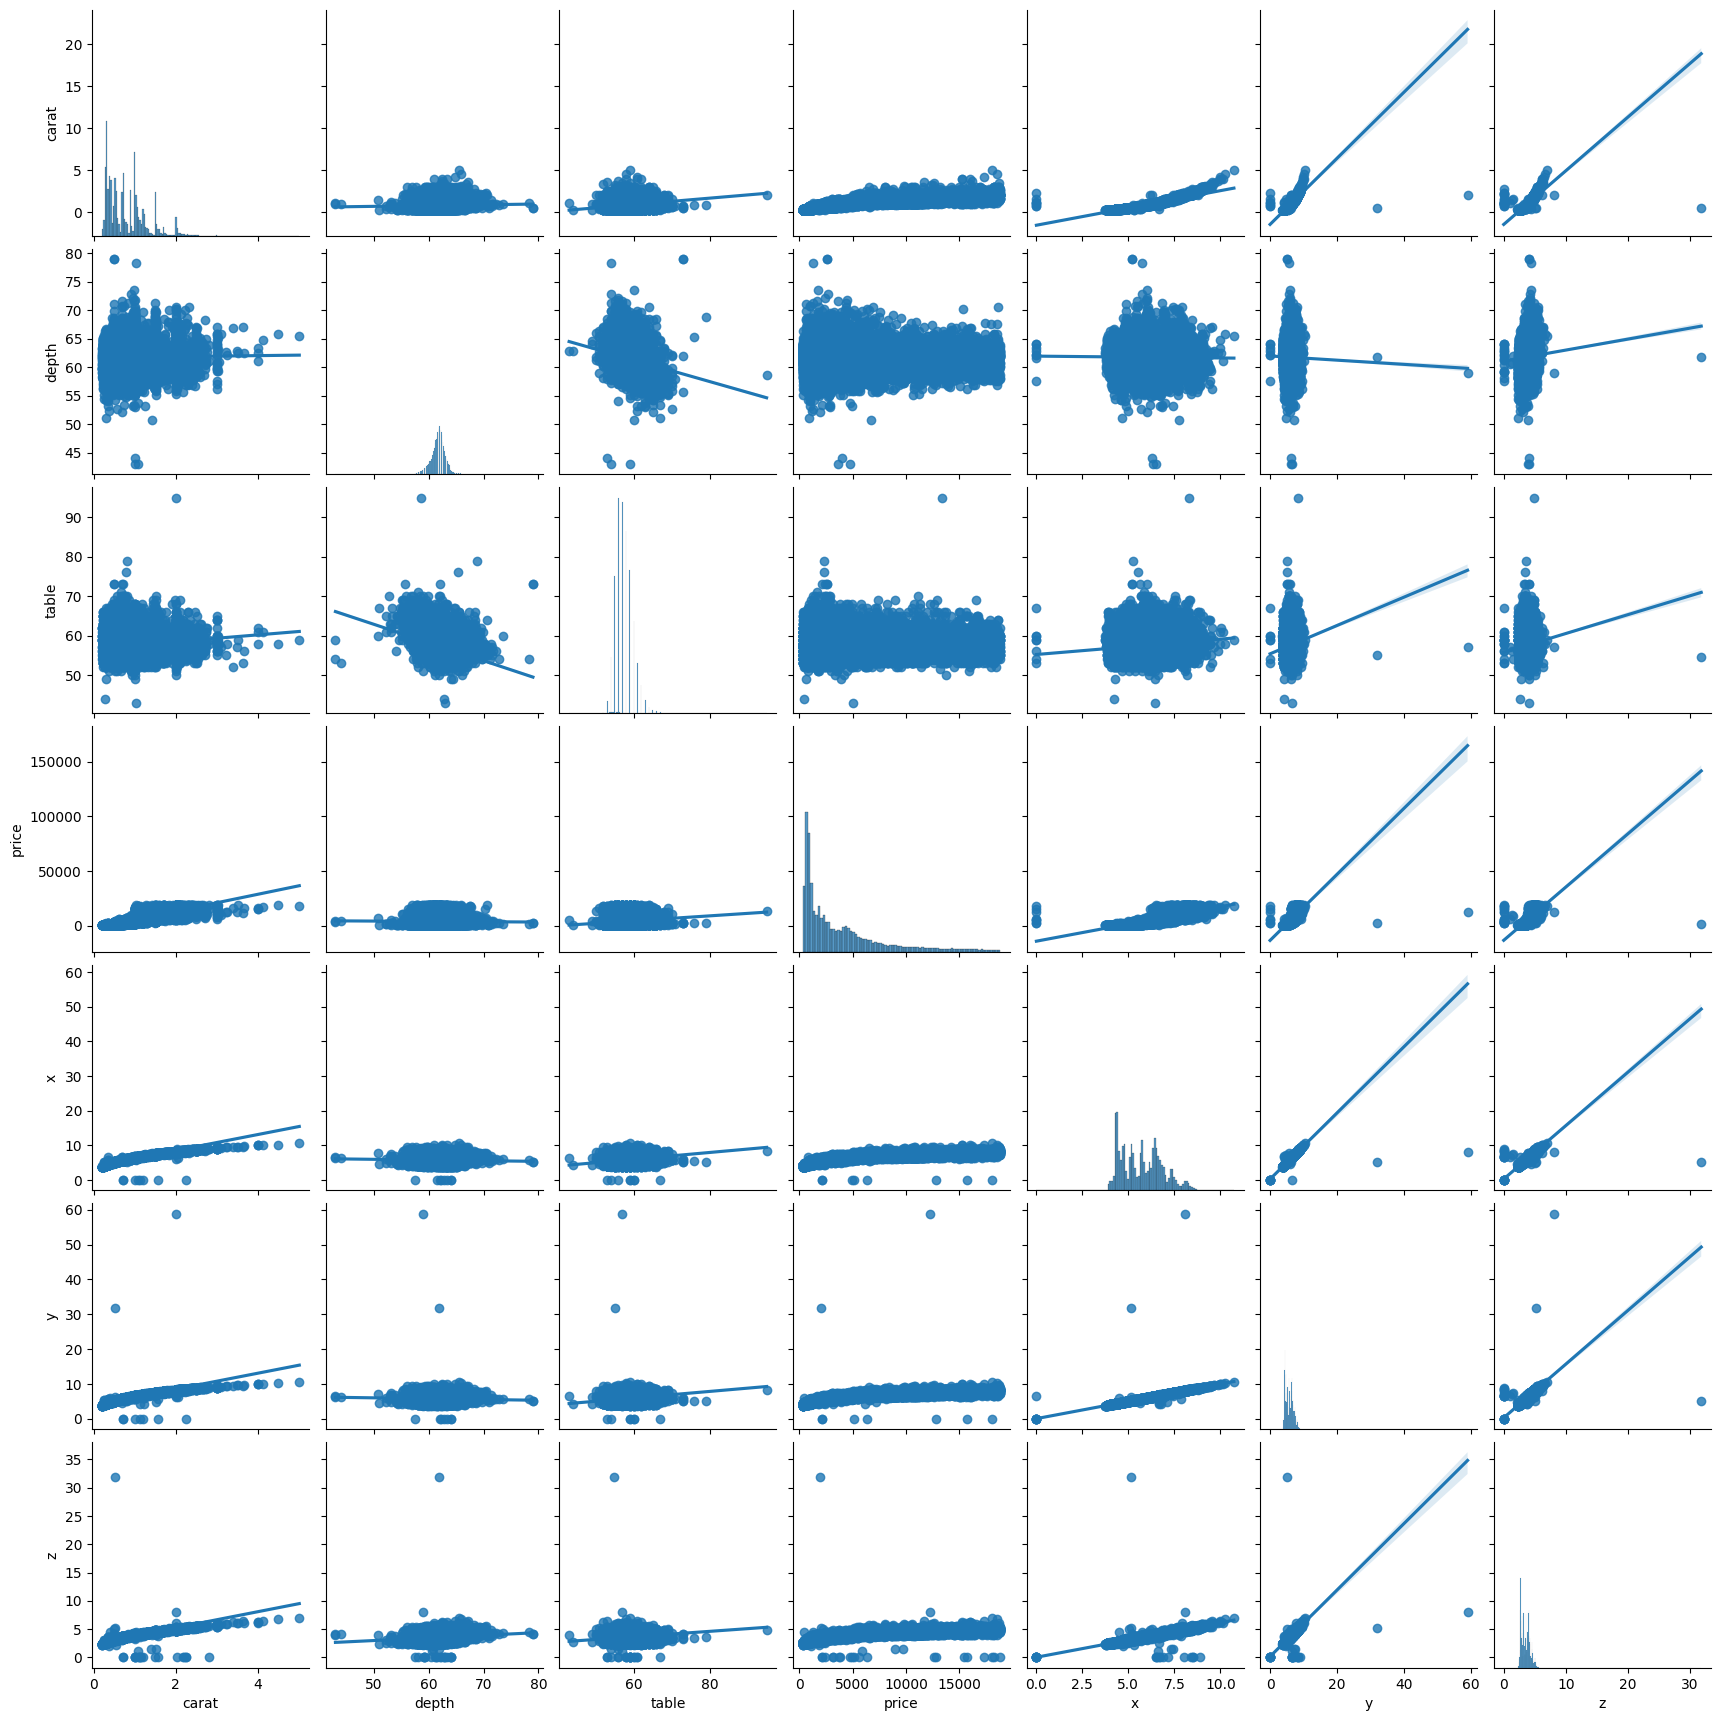

In [113]:
plt.figure(figsize=(30, 20))
sb.pairplot(data=edf, vars=cnames, kind='reg')
plt.show()
plt.close()

> 독립 변수들 중 carat(무게)와 x, y, z (깊이 및 넓이)들이 다중 공선성(강한 상관관계)을 지닌다. 그러므로 독립 변수로 두면 안 된다? 수업에서 이를 언급하였으나 자세히는 기억이 안나고 앞으로의 코딩들을 보면 그냥 그대로 두고 분석을 수행한 듯 보인다.

#### 4. PCA 분석
- `회귀분석에 필요한 요인들은 선정`하기 위해 주성분 분석을 수행한다.
- 나중에 ols로 분석할 때 x, y, z 값들은 제외
##### 데이터 표준화
- 범주형은 PCA를 수행할 수 없기 때문에 `edf`에서 수치형 변수만 추출하여 처리
- 종속 변수인 가격은 제외하고 진행

In [114]:
x_train_std_df, y_train_std_df = helper.scalling(edf[cnames], 'price')
# scalling(df, 종속변수명)는 표준화 된 독립변수 df랑 종속변수 df를 return
print(x_train_std_df, y_train_std_df)

          carat     depth     table         x         y         z
0     -1.198168 -0.174092 -1.099672 -1.587837 -1.536196 -1.571129
1     -1.240361 -1.360738  1.585529 -1.641325 -1.658774 -1.741175
2     -1.198168 -3.385019  3.375663 -1.498691 -1.457395 -1.741175
3     -1.071587  0.454133  0.242928 -1.364971 -1.317305 -1.287720
4     -1.029394  1.082358  0.242928 -1.240167 -1.212238 -1.117674
...         ...       ...       ...       ...       ...       ...
53935 -0.164427 -0.662711 -0.204605  0.016798  0.022304 -0.054888
53936 -0.164427  0.942753 -1.099672 -0.036690  0.013548  0.100988
53937 -0.206621  0.733344  1.137995 -0.063434 -0.047741  0.030135
53938  0.130927 -0.523105  0.242928  0.373383  0.337506  0.285204
53939 -0.101137  0.314528 -1.099672  0.088115  0.118616  0.143499

[53940 rows x 6 columns]           price
0     -0.904095
1     -0.904095
2     -0.903844
3     -0.902090
4     -0.901839
...         ...
53935 -0.294731
53936 -0.294731
53937 -0.294731
53938 -0.294731
53939 

##### PCA
- 표준화 결과를 활용하여 주성분 분석 수행

In [115]:
model = pca()
my_fit = model.fit_transform(x_train_std_df)
topfeat = my_fit['topfeat']
topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,x,0.500910,best
1,PC2,depth,-0.734082,best
2,PC3,table,0.732523,best
3,PC1,carat,0.495367,weak
4,PC1,y,0.495218,weak
5,PC1,z,0.493882,weak


##### 주성분 선정

In [116]:
best = topfeat.query('type == "best"')
best_names = list(set(list(best['feature'])))
# 여기서 원하는 값은 list형태인데, list를 한 번만 하면 중복되는 값이 있을 수 있기에
# set으로 변환하여 중복되는 값은 제거한 후 다시 list로 묶은 것임
best_names

['table', 'x', 'depth']

### 2) 범주형 변수
#### 1. 범주형만 추출

In [1]:
cnames = []
dtypes = edf.dtypes

for i, v in enumerate(dtypes):
    if v == 'category':
        print(dtypes.index[i], dtypes[j])
        cnames.append(dtypes.index[i])

print(cnames)

NameError: name 'edf' is not defined

#### 2. 범주형 데이터 분포 확인

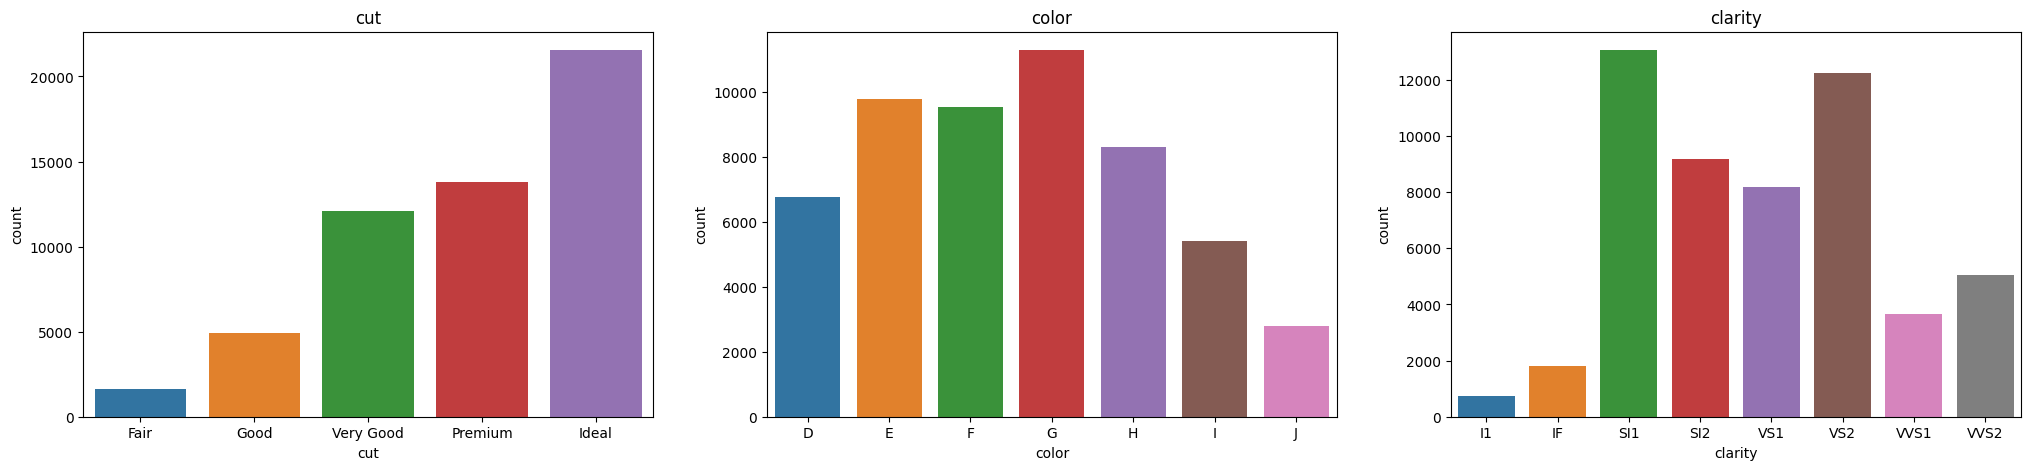

In [118]:
fig, ax = plt.subplots(1, len(cnames), figsize = (25, 5))

for i, v in enumerate(cnames):
    vc = DataFrame(edf[v].value_counts(), columns=['count'])
    # print(vc)
    sb.barplot(data=vc, x=vc.index, y='count', ax=ax[i])
    ax[i].set_title(v)

plt.show()
plt.close()

#### 3. `cut` 변수에 대한 분산 분석 및 검정
##### 데이터 타입 확인

In [119]:
edf['cut'].dtypes

CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)

> 범주형이므로 범주형 변수에 대한 라벨링 값 생성

##### 범주형 변수에 대한 라벨링 값 생성

In [120]:
# 범주형 변수의 종류 추출
edf['cut'].dtypes.categories

# 라벨링 값 생성
mydict = {}
for i, v in enumerate(edf['cut'].dtypes.categories):
    mydict[v] = i
mydict

# 라벨링 처리
tmp_df = edf.filter(['price', 'cut'])
tmp_df['cut'] = tmp_df['cut'].map(mydict).astype('int')
tmp_df

,price,cut
0,326,4
1,326,3
2,327,1
3,334,3
4,335,1
...,...,...
53935,2757,4
53936,2757,1
53937,2757,2
53938,2757,3


##### 분산 분석에 대한 적합성 검정

In [121]:
helper.allTest(tmp_df['price'], tmp_df['cut'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+----------+--------------+----------+-------------+-----------+----------+
|          | field        | test     |   statistic |   p-value | result   |
|----------+--------------+----------+-------------+-----------+----------|
| 정규성   | price        | shapiro  |    0.798108 |         0 | False    |
| 정규성   | cut          | shapiro  |    0.840702 |         0 | False    |
| 정규성   | price        | shapiro  |     15096.6 |         0 | False    |
| 정규성   | cut          | shapiro  |     4332.54 |         0 | False    |
| 정규성   | price vs cut | ks_2samp |           1 |         0 | False    |
| 정규성   | cut vs price | ks_2samp |           1 |         0 | False    |
| 등분산성 | price vs cut | Bartlett |      807780 |         0 | False    |
| 등분산성 | price vs cut | Fligner  |     67384.1 |         0 | False    |
| 등분산성 | price vs cut | Levene   |     40950.1 |         0 | False    |
| 독립성   | price vs cut | Chi2     |      324145 |         0 | False    |
+----------+--------------+----------+-------

> result가 다 False인것을 보아,
>
> 조건을 충족하지 않으므로 이 요인을 제외하는 것으로 결정

#### 4. `color` 변수에 대한 분산 분석 및 검정

In [122]:
yname = 'price'
xname = 'color'
mydict = {}

for i, v in enumerate(edf[xname].dtypes.categories):
    mydict[v] = i
# mydict

tmp_df = edf.filter([yname, xname])
tmp_df[xname] = tmp_df[xname].map(mydict).astype('int')
# tmp_df

helper.allTest(tmp_df[yname], tmp_df[xname])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+----------+----------------+----------+-------------+-----------+----------+
|          | field          | test     |   statistic |   p-value | result   |
|----------+----------------+----------+-------------+-----------+----------|
| 정규성   | price          | shapiro  |    0.798108 |         0 | False    |
| 정규성   | color          | shapiro  |    0.940571 |         0 | False    |
| 정규성   | price          | shapiro  |     15096.6 |         0 | False    |
| 정규성   | color          | shapiro  |      6626.9 |         0 | False    |
| 정규성   | price vs color | ks_2samp |           1 |         0 | False    |
| 정규성   | color vs price | ks_2samp |           1 |         0 | False    |
| 등분산성 | price vs color | Bartlett |      762365 |         0 | False    |
| 등분산성 | price vs color | Fligner  |     66621.1 |         0 | False    |
| 등분산성 | price vs color | Levene   |     40934.5 |         0 | False    |
| 독립성   | price vs color | Chi2     |      334347 |         0 | False    |
+----------+-------

> result가 다 False인것을 보아,
>
> 조건을 충족하지 않으므로 이 요인을 제외하는 것으로 결정

#### 5. `clarity` 변수에 대한 분산 분석 및 검정

In [123]:
yname = 'price'
xname = 'clarity'
mydict = {}

for i, v in enumerate(edf[xname].dtypes.categories):
    mydict[v] = i
# mydict

tmp_df = edf.filter([yname, xname])
tmp_df[xname] = tmp_df[xname].map(mydict).astype('int')
# tmp_df

helper.allTest(tmp_df[yname], tmp_df[xname])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+----------+------------------+----------+-------------+-----------+----------+
|          | field            | test     |   statistic |   p-value | result   |
|----------+------------------+----------+-------------+-----------+----------|
| 정규성   | price            | shapiro  |    0.798108 |         0 | False    |
| 정규성   | clarity          | shapiro  |    0.935034 |         0 | False    |
| 정규성   | price            | shapiro  |     15096.6 |         0 | False    |
| 정규성   | clarity          | shapiro  |     5334.54 |         0 | False    |
| 정규성   | price vs clarity | ks_2samp |           1 |         0 | False    |
| 정규성   | clarity vs price | ks_2samp |           1 |         0 | False    |
| 등분산성 | price vs clarity | Bartlett |      760886 |         0 | False    |
| 등분산성 | price vs clarity | Fligner  |     66703.3 |         0 | False    |
| 등분산성 | price vs clarity | Levene   |     40933.8 |         0 | False    |
| 독립성   | price vs clarity | Chi2     |      492832 |         0 | Fals

> result가 다 False인것을 보아,
>
> 조건을 충족하지 않으므로 이 요인을 제외하는 것으로 결정

## 4. 회귀분석 수행
### 1) 최종 요인 선정
- 검정 결과 범주형 변수는 정규성, 등분산성, 독립성을 충족하지 않기 때문에 요인에서 제외함
- 그러므로 최초에 생성했던 수치형 변수들에 대한 표준화 결과로만 구성된 데이터프레임 생성함
- 그 후 생성된 데이터프레임에서 PCA 분석 결과로 선정된 독립변수들과 종속변수만 추출함

In [124]:
best_names

['table', 'x', 'depth']

In [125]:
target_names = best_names + ['price']
merge_df = merge(x_train_std_df, y_train_std_df, 
                 left_index = True,
                 right_index = True)
df = merge_df.filter(target_names)
df

,table,x,depth,price
0,-1.099672,-1.587837,-0.174092,-0.904095
1,1.585529,-1.641325,-1.360738,-0.904095
2,3.375663,-1.498691,-3.385019,-0.903844
3,0.242928,-1.364971,0.454133,-0.902090
4,0.242928,-1.240167,1.082358,-0.901839
...,...,...,...,...
53935,-0.204605,0.016798,-0.662711,-0.294731
53936,-1.099672,-0.036690,0.942753,-0.294731
53937,1.137995,-0.063434,0.733344,-0.294731
53938,0.242928,0.373383,-0.523105,-0.294731


### 2) 1차 회귀분석 수행
#### 1. 분석

In [126]:
ols_result = helper.myOls(df, y='price', x=best_names)
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 6.541e+04
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:24:09   Log-Likelihood:                -35157.
No. Observations:               53940   AIC:                         7.032e+04
Df Residuals:                   53936   BIC:                         7.036e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.153e-15      0.002  -5.77e-13      1.0

#### 2. 결과 보고

In [72]:
ols_result.table

B   표준오차  β         t   유의확률       VIF
종속변수  독립변수                                               
price table  -0.0481  0.002  0  -22.549*  0.000  1.150738
      x       0.8938  0.002  0  438.159*  0.000  4.746060
      depth  -0.0023  0.002  0   -1.090*  0.276  1.097216

In [73]:
print(ols_result.result, end = '\n\n')
print(ols_result.goodness, end = '\n\n')
for i in ols_result.varstr:
    print(i)

𝑅(0.784), 𝑅^2(0.784), 𝐹(6.541e+04), 유의확률(0.00), Durbin-Watson(0.448)

price에 대하여 table,x,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,53936) = 6.541e+04, p < 0.05).

table의 회귀계수는 -0.0481(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
x의 회귀계수는 0.8938(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
depth의 회귀계수는 -0.0023(p>0.05)로, price에 대하여 유의하지 않은 예측변인인 것으로 나타났다.


#### 3. 2차 분석 수행
- 통계적으로 유의하지 않은 `depth를 제외`하고 다시 수행하여 설명력의 차이를 확인함
##### 요인 제거

In [75]:
df2 = df.drop('depth', axis = 1)
df2

,table,x,price
0,-1.099672,-1.587837,-0.904095
1,1.585529,-1.641325,-0.904095
2,3.375663,-1.498691,-0.903844
3,0.242928,-1.364971,-0.902090
4,0.242928,-1.240167,-0.901839
...,...,...,...
53935,-0.204605,0.016798,-0.294731
53936,-1.099672,-0.036690,-0.294731
53937,1.137995,-0.063434,-0.294731
53938,0.242928,0.373383,-0.294731


##### 분석 수행 및 결과보고

In [76]:
ols_result = helper.myOls(df2, y='price', x=['x', 'table'])
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 9.811e+04
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:46:50   Log-Likelihood:                -35158.
No. Observations:               53940   AIC:                         7.032e+04
Df Residuals:                   53937   BIC:                         7.035e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.153e-15      0.002  -5.77e-13      1.0

In [77]:
# 결과 보고
ols_result.table

B   표준오차  β         t   유의확률       VIF
종속변수  독립변수                                               
price x       0.8937  0.002  0  438.384*  0.000  4.744087
      table  -0.0474  0.002  0  -23.273*  0.000  1.050114

In [85]:
sdf = DataFrame({
    '관측값': df2['price'],
    '예측값': ols_result.fit.fittedvalues,
    '잔차': ols_result.fit.resid,
    'zscore': stats.zscore(ols_result.fit.fittedvalues)
})
sdf

,관측값,예측값,잔차,zscore
0,-0.904095,-1.366881,0.462786,-1.543350
1,-0.904095,-1.542085,0.637990,-1.741174
2,-0.903844,-1.499547,0.595702,-1.693144
3,-0.902090,-1.231406,0.329316,-1.390384
4,-0.901839,-1.119867,0.218028,-1.264446
...,...,...,...,...
53935,-0.294731,0.024720,-0.319451,0.027911
53936,-0.294731,0.019385,-0.314116,0.021888
53937,-0.294731,-0.110685,-0.184046,-0.124974
53938,-0.294731,0.322168,-0.616899,0.363761


In [86]:
print(ols_result.result, end='\n\n')
print(ols_result.goodness, end='\n\n')
for i in ols_result.varstr:
    print(i)

𝑅(0.784), 𝑅^2(0.784), 𝐹(9.811e+04), 유의확률(0.00), Durbin-Watson(0.447)

price에 대하여 x,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,53937) = 9.811e+04, p < 0.05).

x의 회귀계수는 0.8937(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
table의 회귀계수는 -0.0474(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.


#### 4. 잔차 분석
##### 잔차의 정규성 - Q-Q Plot
- 생성한 결과치로 `Q-Q Plot`으로 `잔차의 정규성 검정`

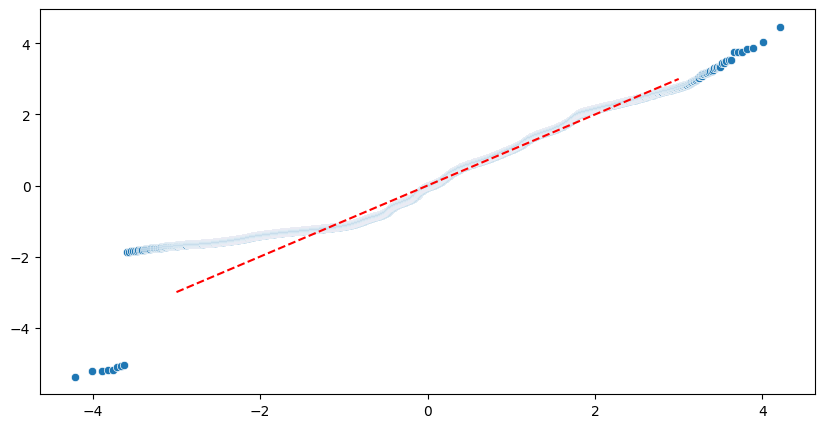

In [87]:
(x, y), _ = stats.probplot(sdf['zscore'])

plt.figure(figsize = (10, 5))
sb.scatterplot(x=x, y=y)
sb.lineplot(x=[-3, 3], y=[-3, 3], color = 'red', linestyle = '--')
plt.show()
plt.close()

##### 잔차의 정규성 - Kolmogorov Smirnov 검정 (정규성 검정 방법 중 하나)
- 생성한 결과치로 `Kolmogorov Smirnov 검정`으로 `잔차의 정규성 검정`
- `stats.kstest(잔차, 'norm')`

In [88]:
s, p = stats.kstest(sdf['잔차'], 'norm')
print("Kolmogorov Smirnov Test: (통계량, p-value) = ", (s, p))

if p > 0.05:
    print('잔차는 정규 분포를 따릅니다. (귀무가설 채택)')
else:
    print('잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)')

Kolmogorov Smirnov Test: (통계량, p-value) =  (0.2265594307504612, 0.0)
잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)


##### 잔차의 등분산성 (브로이슈 패건 검정)

In [89]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = het_breuschpagan(ols_result.fit.resid,
                               ols_result.fit.model.exog)
DataFrame(test_result, index=names)

,0
Lagrange multiplier statistic,3725.868031
p-value,0.000000
f-value,2001.051657
f p-value,0.000000


##### 잔차의 독립성 (Durbin-Watson)

In [92]:
ols_result.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 9.811e+04
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:46:50   Log-Likelihood:                -35158.
No. Observations:               53940   AIC:                         7.032e+04
Df Residuals:                   53937   BIC:                         7.035e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.153e-15      0.002  -5.77e-13      1.000      -0.004       0.004
x              0.8937      0.002    438.384      0.000       0.890       0.898
table         -0.0474      0.002    -23.273      0.000      -0.051      -0.043
==============================================================================
Omnibus:                    19295.614   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           154581.681
Skew:                           1.505   Prob(JB):                         0.00
Kurtosis:                      10.728   Cond. No.                         1.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 독립성: 일반적으로 DW값이 `1.5 ~ 2.5` 범위에 있으면 독립으로 판정되나 여기서는 `0.447`이므로 독립성 미충족
>
> 위의 각종 검정 결과(잔차 분석)를 종합 후, 앞서 했던 분석 결과를 신뢰할 수 없는 것으로 판단하고 재시도해야 되는 것으로 보이나,
> 
> ***최근 잔차분석을 통한 정규성 검정보다 더 많이 인용되고 있는 기준인 정규분포 가정을 시행
> 
> 정규분포 가정: 탐색적 데이터 분석 과정에서 모든 독립변수에 대해 `왜도와 첨도`를 검사

#### 5. 정규분포 가정: 왜도, 첨도 검사

- 다변량 분석에서 왜도와 첨도에 의한 정규분포 기준
    - West et al(1995)의 `정규분포 기준은 |왜도| < 3, |첨도| < 8`
        > West, S. G., Finch, J. F., & Curran, P. J. (1995). Structural equation models with nonnormal variables: Problems and remedies. In R. H. Hoyle (Ed.), Structural equation modeling: Concepts, issues, and applications (p. 56–75). Sage Publications, Inc.
    - Hong et al(2003)의 `정규분포 기준은 |왜도| < 2, |첨도| < 4`
        > Hong, S., Malik, M. L., & Lee, M.-K. (2003). Testing configural, metric, scalar, and latent mean invariance across genders in sociotropy and autonomy using a non-Western sample. Educational and Psychological Measurement, 63(4), 636–654.

##### 왜도
- 분포의 비대칭도

| 구분 | 내용 |
|-:|-|
| 정규분포 | $왜도=0$ |
| 왼쪽으로 치우침 | $왜도 > 0$ |
| 오른쪽으로 치우침 | $왜도 < 0$ |

In [130]:
print(skew(df2['x']))
print(skew(df2['table']))

0.3786658120772089
0.7968736878796515


> 왜도의 절대값이 3보다 작으므로 정규분포 기준 통과 (정규분포를 따르는 것으로 판단)


##### 첨도
- 확률분포의 뾰족한 정도
- Fisher = True
    - 첨도 기준이 Fisher (normal ==> 0.0)
    - 정규분포의 첨도 = 0

| 구분 | 내용 |
|---|---|
| 정규분포 | $첨도 = 0$ |
| 위로 뾰족함 | $첨도 > 0$ |
| 아래로 뾰족함 | $첨도 < 0$ |

- Fisher = False
    - 첨도 기준이 Pearson (normal ==> 3.0)
    - 정규분포의 첨도 = 3

| 구분 | 내용 |
|---|---|
| 정규분포 | $첨도 = 3$ |
| 위로 뾰족함 | $첨도 > 3$ |
| 아래로 뾰족함 | $첨도 < 3$ |

In [132]:
print(kurtosis(df2['x'], fisher = True))
print(kurtosis(df2['table'], fisher = True))

-0.6182146042773287
2.8014859143615753


> 첨도의 절대값이 8보다 작으므로 정규분포를 따르는 것으로 판단